## Projeto

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.optimize import AdamOptimizer
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates.embeddings import AngleEmbedding
from tqdm.notebook import tqdm, trange

In [2]:

# Read the HDF5 file using pandas
data_frame_fcnc = pd.read_hdf('fcnc_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_fcnc.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_fcnc.head()


Number of rows: 90548


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,1.408853,15.150869,339.182312,2.350262,1.396943,0.710451,0.109013,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,test,7.762202e-09,0.001285
1,1,-2.481838,7.208333,247.036240,-2.280740,0.428710,0.205213,0.000000,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,val,7.762202e-09,0.001285
2,0,1.476267,94.220718,238.014694,-1.788097,94.256210,2.418446,1.585315,1.127324,0.431098,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
3,1,0.647480,13.459283,230.971832,-1.032663,1.227122,0.467150,0.164008,0.000000,0.000000,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285
4,0,2.106436,97.490242,698.399902,-3.059983,36.555862,2.937936,1.799140,1.093004,0.589724,...,0,None,PyDelphes,signal,1,tZFCNC,tZFCNC_PyDelphes,train,7.762249e-09,0.001285


In [3]:
# Read the HDF5 file using pandas
data_frame_bkg = pd.read_hdf('bkg_pythia_sanitised_features.h5')

# Get the number of rows
num_rows = data_frame_bkg.shape[0]

print('Number of rows: {}'.format(num_rows))

# Explore the data
data_frame_bkg.head()


Number of rows: 1002490


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,gen_decay2,gen_decay_filter,gen_filter,gen_label,gen_n_btags,gen_sample,gen_sample_filter,gen_split,gen_weights,gen_xsec
0,2,-1.988600,52.710262,229.350952,0.728242,36.148926,23.039709,16.949991,14.424411,12.000529,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,train,0.000018,11.9635
1,0,0.528382,61.115589,315.538910,-0.863614,32.592808,22.366640,16.285843,13.938633,11.180016,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,test,0.000018,11.9635
2,0,1.479911,98.012802,251.109573,-3.133624,90.252274,33.646885,30.612156,27.973904,23.729696,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
3,2,0.926899,-0.000007,240.909348,0.835656,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635
4,0,0.781194,72.234299,206.020386,-0.320449,48.886372,20.743645,16.572512,13.070706,11.269534,...,0,2L,HT250to500,bkg,1,Zjj,Zjj_HT250to500,val,0.000018,11.9635


#### Normalize the data

In [8]:
# Z-score normalization

# copy the data to a new dataframe
data_frame_fcnc_norm = data_frame_fcnc.copy()
data_frame_bkg_norm = data_frame_bkg.copy()

# normalize the data except the categorical features and the weights
for feature in data_frame_fcnc.columns:
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split', 'gen_decay2','gen_decay1', 'gen_xsec']:
        pass
    else: 
        data_frame_fcnc_norm[feature] = (data_frame_fcnc[feature] - data_frame_fcnc[feature].mean()) / data_frame_fcnc[feature].std()
        
for feature in data_frame_bkg.columns:
    if feature in ['gen_decay_filter', 'gen_filter', 'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter', 'gen_split','gen_decay2','gen_decay1','gen_xsec']:
        pass
    else:  
        data_frame_bkg_norm[feature] = (data_frame_bkg[feature] - data_frame_bkg[feature].mean()) / data_frame_bkg[feature].std()

### SVMs

#### Data preprocessing 

In [11]:
# change the signal and bkg labels to 0 and 1 and get the labels for each dataset
data_frame_fcnc_norm = data_frame_fcnc_norm.replace(['signal'], 1)
data_frame_bkg_norm = data_frame_bkg_norm.replace(['bkg'], 0)

# Split the data into train, validation and test sets for each dataset

data_frame_fcnc_norm_train = data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_split'] == 'train']
data_frame_bkg_norm_train =  data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_split'] == 'train']
a,_ = data_frame_fcnc_norm_train.shape

data_frame_fcnc_norm_test = data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_split'] == 'test']
data_frame_bkg_norm_test =  data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_split'] == 'test']

b,_ = data_frame_fcnc_norm_test.shape

data_frame_fcnc_norm_val = data_frame_fcnc_norm.loc[data_frame_fcnc_norm['gen_split'] == 'val']
data_frame_bkg_norm_val =  data_frame_bkg_norm.loc[data_frame_bkg_norm['gen_split'] == 'val']

c,_ = data_frame_fcnc_norm_val.shape


# get 5000 points of each dataset
train_fcnc = data_frame_fcnc_norm_train.sample(n=5000)
train_bkg = data_frame_bkg_norm_train.sample(n=5000)
# get 10 batches of 500 points of each dataset and join them
train_batches = [pd.concat([train_fcnc[i*500:(i+1)*500], train_bkg]) for i in range(10)]
# shuffle each batch
for i in range(10):
    train_batches[i] = train_batches[i].sample(frac=1)

# get 5000 points of each dataset
test_fcnc = data_frame_fcnc_norm_test.sample(n=5000)
test_bkg = data_frame_bkg_norm_test.sample(n=5000)
# get 10 batches of 500 points of each dataset and join them
test_batches = [pd.concat([test_fcnc[i*500:(i+1)*500], test_bkg]) for i in range(10)]
# shuffle each batch
for i in range(10):
    test_batches[i] = test_batches[i].sample(frac=1)

# get 5000 points of each dataset
val_fcnc = data_frame_fcnc_norm_val.sample(n=5000)
val_bkg = data_frame_bkg_norm_val.sample(n=5000)
# get 10 batches of 500 points of each dataset and join them
val_batches = [pd.concat([val_fcnc[i*500:(i+1)*500], val_bkg]) for i in range(10)]
# shuffle each batch
for i in range(10):
    val_batches[i] = val_batches[i].sample(frac=1)


# get the weights for each dataset
w_train_batches = [train_batches[i][['gen_xsec']] for i in range(10)]
w_test_batches = [test_batches[i][['gen_xsec']] for i in range(10)]
w_val_batches = [val_batches[i][['gen_xsec']] for i in range(10)]




#### Train

In [12]:
# transform y_train into a single array instead of  a dataframe
y_train_arr = np.concatenate( y_train.values, axis=0 )


In [13]:
# Renormalize weights
w_train[y_train_arr == 1] = (w_train[y_train_arr == 1] / w_train[y_train_arr == 1].sum()) * w_train.shape[0] / 2
w_train[y_train_arr == 0] = (w_train[y_train_arr == 0] / w_train[y_train_arr == 0].sum()) * w_train.shape[0] / 2


# Train SMV
clf = svm.SVC(kernel="rbf", probability=True)   
clf.fit(x_train, y_train_arr,sample_weight=w_train.values.ravel())


SVC(probability=True)

#### Validation

In [14]:
# transform y_val into a single array instead of  a dataframe
y_val_arr = np.concatenate( y_val.values, axis=0 )

# Renormalize weights
w_val[y_val_arr == 1] = (w_val[y_val_arr == 1] / w_val[y_val_arr == 1].sum()) * w_val.shape[0] / 2
w_val[y_val_arr == 0] = (w_val[y_val_arr == 0] / w_val[y_val_arr == 0].sum()) * w_val.shape[0] / 2

# Predict
y_val_scores = clf.predict_proba(x_val)
y_val_scores = y_val_scores[:, 1]
y_val_pred = clf.predict(x_val)

# Compute metrics
accuracy = accuracy_score(y_val, y_val_pred)
auc_score = roc_auc_score(y_val, y_val_scores,sample_weight=w_val.values.ravel())

print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.664
ROC AUC Score: 0.9868798253991998


#### Test

In [15]:
# transform y_val into a single array instead of a dataframe
y_test_arr = np.concatenate( y_test.values, axis=0 )

# Renormalize weights
w_test[y_test_arr == 1] = (w_test[y_test_arr == 1] / w_test[y_test_arr == 1].sum()) * w_test.shape[0] / 2
w_test[y_test_arr == 0] = (w_test[y_test_arr == 0] / w_test[y_test_arr == 0].sum()) * w_test.shape[0] / 2

# Predict
y_test_scores = clf.predict_proba(x_test)
y_test_scores = y_test_scores[:, 1]
y_pred = clf.predict(x_test)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test.values.ravel())
auc_score = roc_auc_score(y_test, y_test_scores, sample_weight=w_test.values.ravel())
print("Accuracy:", accuracy)
print("ROC AUC Score:", auc_score)

Accuracy: 0.8259815540991738
ROC AUC Score: 0.9959249192937498


/tmp/ipykernel_341102/3111753021.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color='orange')


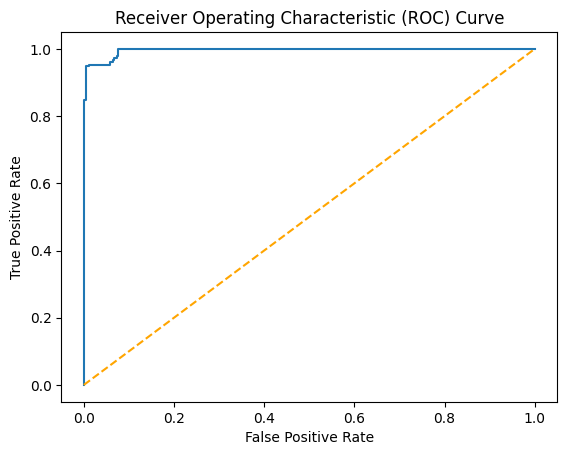

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores,sample_weight=w_test.values.ravel())

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--', color='orange')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

[2.23117949e+02 6.68498830e+00 1.89484930e+00 1.90028357e+00
 5.14083442e-01 1.46702749e+00 1.14923720e+01 1.19084096e-02
 1.45464203e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.19084096e-02 1.19084096e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.19084096e-02 0.00000000e+00 1.39044646e+00 0.00000000e+00
 1.19084096e-02 2.38168192e-02]
[0.00000000e+00 0.00000000e+00 3.03354214e+00 1.46252088e+00
 1.46655044e+00 2.38168192e-02 0.00000000e+00 1.19084096e-02
 1.72424313e-01 0.00000000e+00 7.87884595e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.38966127e+00 0.00000000e+00 1.72424313e-01 0.00000000e+00
 7.87884595e-03 1.46655044e+00 1.96958853e-02 0.00000000e+00
 1.65500410e+00 1.47845885e+00 9.10139434e+01 1.43614603e+02
 1.57775191e+00 1.42538650e+00]


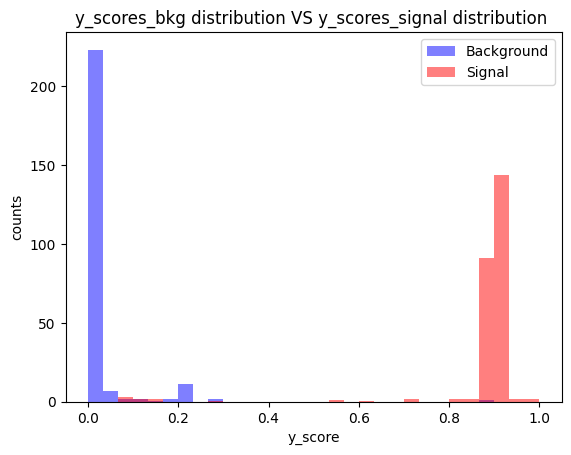

In [17]:
# Plot signal and background distributions for the predicted scores with normalized counts and log scale

num_bins = 30  # Number of bins

# Compute the range for the bins based on the minimum and maximum values of the data
min_value = min(min(y_test_scores[y_test_arr == 0]), min(y_test_scores[y_test_arr == 1]))
max_value = max(max(y_test_scores[y_test_arr == 0]), max(y_test_scores[y_test_arr == 1]))
bin_range = (min_value, max_value)

counts, bins, _ = plt.hist(y_test_scores[y_test_arr == 0], bins=num_bins, range=bin_range,  weights=w_test[y_test_arr==0], alpha=0.5, color='b', label='Background')
counts2, bins2, _ = plt.hist(y_test_scores[y_test_arr == 1], bins=num_bins, range=bin_range,weights=w_test[y_test_arr==0], alpha=0.5, color='r', label='Signal')

print(counts)
print(counts2)

plt.xlabel('y_score')
plt.ylabel('counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

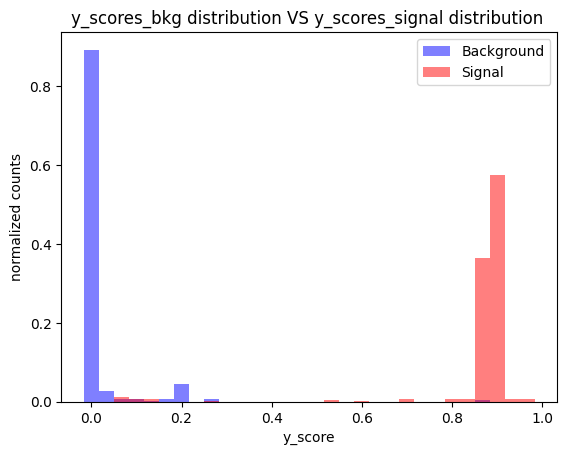

In [18]:
# Plot signal and background distributions for the predicted scores with normalized counts

counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('normalized counts')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.legend()
plt.show()

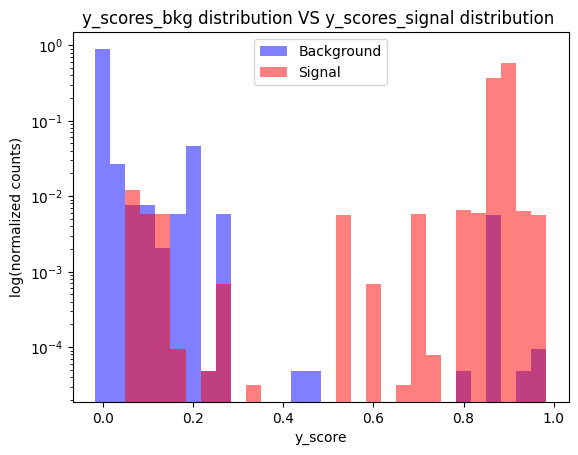

In [19]:
# Normalize the counts
counts = counts / sum(counts)
counts2 = counts2 / sum(counts2)

plt.bar(bins[:-1], counts, width=np.diff(bins), alpha=0.5, color='b', label='Background')
plt.bar(bins2[:-1], counts2, width=np.diff(bins2), alpha=0.5, color='r', label='Signal')

plt.xlabel('y_score')
plt.ylabel('log(normalized counts)')
plt.title('y_scores_bkg distribution VS y_scores_signal distribution ')
plt.yscale('log')
plt.legend()
plt.show()

### VQC

#### Pennylane (V1)

In [20]:
# Split the original data into train, validation and test sets for each dataset
data_frame_fcnc_train = data_frame_fcnc.loc[data_frame_fcnc['gen_split'] == 'train']
data_frame_bkg_train =  data_frame_bkg.loc[data_frame_bkg['gen_split'] == 'train']

data_frame_fcnc_test = data_frame_fcnc.loc[data_frame_fcnc['gen_split'] == 'test']
data_frame_bkg_test =  data_frame_bkg.loc[data_frame_bkg['gen_split'] == 'test']

data_frame_fcnc_val = data_frame_fcnc.loc[data_frame_fcnc['gen_split'] == 'val']
data_frame_bkg_val =  data_frame_bkg.loc[data_frame_bkg['gen_split'] == 'val']


# get 500 points of each dataset and  join the datasets (randomly)
train_fcnc = data_frame_fcnc_train.sample(n=250)
train_bkg = data_frame_bkg_train.sample(n=250)
train = pd.concat([train_fcnc, train_bkg])
train = train.sample(frac=1, random_state=42)

test_fcnc = data_frame_fcnc_test.sample(n=250)
test_bkg = data_frame_bkg_test.sample(n=250)
test= pd.concat([test_fcnc, test_bkg])
test = train.sample(frac=1, random_state=42)

val_fnc = data_frame_fcnc_val.sample(n=250)
val_bkg = data_frame_bkg_val.sample(n=250)
val = pd.concat([val_fnc, val_bkg])
val = val.sample(frac=1, random_state=42)

# get the weights for each dataset
w_train = train[['gen_xsec']]
w_test = test[['gen_xsec']]
w_val = val[['gen_xsec']]


# change the signal and bkg labels to 0 and 1 and get the labels for each dataset
train = train.replace(['signal'], 1)
train= train.replace(['bkg'], 0)
y_train = train[['gen_label']]
x_train = train[['MissingET_MET', 'Jet1_BTag']]

test = test.replace(['signal'], 1)
test= test.replace(['bkg'], 0)
y_test = test[['gen_label']]
x_test = test[['MissingET_MET', 'Jet1_BTag']]

val = val.replace(['signal'], 1)
val= val.replace(['bkg'], 0)
y_val = val[['gen_label']]
x_val = val[['MissingET_MET', 'Jet1_BTag']]

y_train_arr = np.concatenate(y_train.values, axis=0 )
y_val_arr = np.concatenate( y_val.values, axis=0 )
y_test_arr = np.concatenate( y_test.values, axis=0 )

# Renormalize data weights
w_train[y_train_arr == 1] = (w_train[y_train_arr == 1] / w_train[y_train_arr == 1].sum()) * y_train_arr.shape[0] / 2
w_train[y_train_arr == 0] = (w_train[y_train_arr == 0] / w_train[y_train_arr == 0].sum()) * y_train_arr.shape[0] / 2
        
w_test[y_test_arr == 1] = (w_test[y_test_arr == 1] / w_test[y_test_arr == 1].sum()) * w_test.shape[0] / 2
w_test[y_test_arr == 0] = (w_test[y_test_arr == 0] / w_test[y_test_arr == 0].sum()) * w_test.shape[0] / 2
        
w_val[y_test_arr == 1] = (w_val[y_test_arr == 1] / w_val[y_test_arr == 1].sum()) * w_val.shape[0] / 2
w_val[y_test_arr == 0] = (w_val[y_test_arr == 0] / w_val[y_test_arr == 0].sum()) * w_val.shape[0] / 2

# Concatenate features
X = np.concatenate([x_train, x_test,x_val])

# Normalize the data for angle embeding  (Put the data between -pi and pi)
X = (((X - X.min()) / (X.max() - X.min())) * 2 - 1) * (np.pi)

# Split the features array into train, validation and test sets
x_train = X[:500]
x_test = X[500:1000]
x_val = X[1000:]

In [21]:
# accuracy function
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss


In [22]:
# loss function
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

# quantum circuit function
def circuit(n_features, n_layers, weights, x):
        # Embedding
        
        qml.AngleEmbedding(x,range (0, n_features),rotation="X" )

        # For every layer
        for layer in range(n_layers):
            W1 = weights[layer]

            # Define Rotations
            for i in range(0,n_features):
                qml.Rot(W1[i, 0], W1[i, 1], W1[i, 2], wires=i)

            # Entanglement
            if n_features != 1:
                if n_features > 2:
                    for i in range(n_features):
                        if i == n_features - 1:
                            qml.CNOT(wires=[i, 0])
                        else:
                            qml.CNOT(wires=[i, i + 1])
                else:
                    qml.CNOT(wires=[1, 0])

        return qml.expval(qml.PauliZ(0))

# classifier function    
def classifier(n_features, n_layers, weights, x):
        #c = circuit(n_features, n_layers, weights, x)
        dev=qml.device("default.qubit", wires=n_features)
        return qml.QNode(circuit, dev)(n_features, n_layers, weights, x)
    
# cost function    
def cost(n_features, n_layers,weights,X,Y,W):  
        # Compute predictions
        y_scores = [(classifier(n_features, n_layers,weights, x) + 1) / 2 for x in X]

        loss = square_loss(Y, y_scores)
        loss = loss * W
        loss = loss.sum()
        
        return loss
    
# train step function    
def train_step(n_features, n_layers,x_train,y_train, w_train, weights, opt,desc='Training'):
        
        # Only require grad if necessary
        x_train = np.array(x_train, requires_grad=False)
        y_train = np.array(y_train, requires_grad=True)
        w_train = np.array(w_train, requires_grad=False)

        # Compute cost and update weights
        weights, loss = opt.step_and_cost(cost, n_features, n_layers,weights, X=x_train, Y=y_train, W=w_train)

        return loss, weights
    
# validation step function
def validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch,best_weights,desc='Validation'):
    X_val = np.array(x_val, requires_grad=False)
    Y_val = np.array(y_val, requires_grad=False)
    W_val = np.array(w_val, requires_grad=False)

    y_scores = np.array([classifier(n_features, n_layers, weights, x) for x in X_val])
    y_scores = (y_scores + 1) / 2

    W_val[Y_val == 1] = (W_val[Y_val == 1] / W_val[Y_val == 1].sum()) * W_val.shape[0] / 2
    W_val[Y_val == 0] = (W_val[Y_val == 0] / W_val[Y_val == 0].sum()) * W_val.shape[0] / 2

    auc_score = roc_auc_score(y_true=Y_val, y_score=y_scores, sample_weight=W_val)
    loss = cost(n_features, n_layers, weights, X_val, Y_val, W_val)


    if best_score is None or auc_score > best_score:
        best_score = auc_score
        best_score_epoch = epoch_number
        best_weights = weights

    tqdm.write(f"Epoch: {epoch_number}, Validation Loss: {loss:.4f}, AUC Score: {auc_score:.4f}")

    return best_score, best_score_epoch, best_weights
        
        
# train function
def train(n_features, n_layers, x_train, y_train, learning_rate, weights, max_epochs, epoch_number):
    opt = AdamOptimizer(learning_rate)
    best_score = None
    best_weights = None
    best_score_epoch = None

    with tqdm(total=max_epochs, desc='Epoch', unit='epoch') as pbar:
        for epoch in range(epoch_number, max_epochs):
            epoch_number = epoch

            loss, nf_nl_weights = train_step(n_features, n_layers, x_train, y_train, w_train, weights, opt, desc='Training')
            
            # Log variable values using tqdm.write
            tqdm.write(f"Epoch: {epoch_number:}, Loss: {loss:.4f}")
            
            
            weights = nf_nl_weights[2:]
            weights = weights[0]

            if epoch_number == max_epochs - 1 or (epoch_number+1)%5==0:
                best_score, best_score_epoch, best_weights = validation_step(n_features, n_layers, x_val, y_val, w_val, weights, best_score, epoch_number, best_score_epoch, best_weights,desc='Validation')
                # early stopping
                if epoch_number - best_score_epoch > 30 and epoch_number > 80:
                    tqdm.write(f"Early stopping at epoch {epoch_number}")
                    break

            pbar.update(1)  # Update progress bar
        tqdm.write(f"Best Score: {best_score:.4f}")            
        
    return best_score, best_weights

In [23]:
# number of features and layers
n_features = 2
n_layers = 3

# Random weight initialization
weights = 0.01 * np.random.randn(n_layers, n_features, 3, requires_grad=True)

# We create a quantum device with n_features "wires" (or qubits)
dev = qml.device('default.qubit', wires=n_features)

# train the model
best_score, best_weights = train (n_features, n_layers,x_train,y_train_arr,0.01, weights, 1000, 0)


Epoch:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Epoch: 0, Loss: 261.3483
Epoch: 1, Loss: 261.0370
Epoch: 2, Loss: 260.4762
Epoch: 3, Loss: 259.6366
Epoch: 4, Loss: 258.5122
Epoch: 4, Validation Loss: 247.5088, AUC Score: 0.2079
Epoch: 5, Loss: 257.1012
Epoch: 6, Loss: 255.4059
Epoch: 7, Loss: 253.4327
Epoch: 8, Loss: 251.1930
Epoch: 9, Loss: 248.7032
Epoch: 9, Validation Loss: 236.9744, AUC Score: 0.2077
Epoch: 10, Loss: 245.9842
Epoch: 11, Loss: 243.0608
Epoch: 12, Loss: 239.9576
Epoch: 13, Loss: 236.6955
Epoch: 14, Loss: 233.2885
Epoch: 14, Validation Loss: 221.6034, AUC Score: 0.2078
Epoch: 15, Loss: 229.7434
Epoch: 16, Loss: 226.0629
Epoch: 17, Loss: 222.2473
Epoch: 18, Loss: 218.2970
Epoch: 19, Loss: 214.2153
Epoch: 19, Validation Loss: 202.9017, AUC Score: 0.2080
Epoch: 20, Loss: 210.0096
Epoch: 21, Loss: 205.6906
Epoch: 22, Loss: 201.2709
Epoch: 23, Loss: 196.7654
Epoch: 24, Loss: 192.1916
Epoch: 24, Validation Loss: 181.6469, AUC Score: 0.2080
Epoch: 25, Loss: 187.5696
Epoch: 26, Loss: 182.9225
Epoch: 27, Loss: 178.2751
Epoc

In [24]:
print (best_score)

0.7890931875857816


In [25]:
# test the model

def test(n_features, n_layers,x_test,y_test,w_test, weights):
        # Remove grad
        X_test = np.array(x_test, requires_grad=False)
        Y_test = np.array(y_test, requires_grad=False)
        W_test = np.array(w_test, requires_grad=False)

        # This will be between -1 and 1, we need to convert to between 0 and 1
        y_scores = np.array([classifier(n_features, n_layers,weights, x) for x in X_test])
        y_scores = (y_scores + 1) / 2

        # Renormalize weights
        W_test[Y_test == 1] = (W_test[Y_test == 1] / W_test[Y_test == 1].sum()) * W_test.shape[0] / 2
        W_test[Y_test == 0] = (W_test[Y_test == 0] / W_test[Y_test == 0].sum()) * W_test.shape[0] / 2

        # Calculate ROC
        auc_score = roc_auc_score(y_true=Y_test, y_score=y_scores, sample_weight=W_test)
        
        return auc_score
    
auc_score = test(n_features, n_layers,x_test,y_test,w_test, best_weights)
print (auc_score)

0.7790329921315001
